# Glacial ice line model with fixed critical temp

In [1]:
import numpy as np
import scipy as scipy
import scipy.stats as stats
import scipy.linalg as linalg
from scipy.integrate import solve_ivp
from scipy.optimize import root
from pprint import pprint

import matplotlib.gridspec as gridspec
import matplotlib.path as mpath
import matplotlib.pyplot as plt

import sys
import os
import copy
import string
import glob
import xarray as xr 

import warnings

from custom_functions import *
from IceLineMod import *

## Parameters

In [2]:
R = 1.                # Surface layer heat capacity (W/m^2K)
Q = 343.              # Annual average insolation (W/m^2)
beta = np.pi*23.5/180 # Obliquity (radians)
a1 = 0.32             # Albedo between ice line latitudes
a2 = 0.62             # Albedo polewards of ice line latitudes
A = 202.              # Greenhouse gas parameter (W/m^2)
B = 1.9               # Outgoing radiation (W/m^2K)
C = 3.04              # Efficiency of heat transport (W/m^2K)
T_c = -10.            # critical temperature (^oC)
p = 0.3               # Ice line response to temp change (1/(K yr))

pars = np.array([R,Q,beta,a1,a2,A,B,C,T_c,p]) # parameter array

In [3]:
# test model run
# define initial conditions
n01 = np.array([-10,-0.5,0.5])   # initial condition 1 
n02 = np.array([10,-0.5,0.5])    # initial condition 2 
tspan = [0,100]                  # time interval to calculate trajectory 
h = 0.1                          # time step size

# Solve the ODE
[X,t,xeq1] = MyIVP(lambda t,n:IL(t,n,pars),n01,tspan,h);
[X2,t2,xeq2] = MyIVP(lambda t,n:IL(t,n,pars),n02,tspan,h);

X = np.squeeze(X)
xeq1 = np.squeeze(xeq1)
X2 = np.squeeze(X2)
xeq2 = np.squeeze(xeq2)

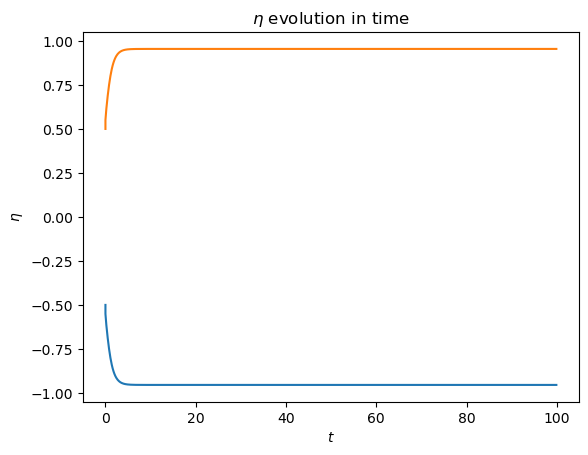

In [4]:
# plot solution trajectory
plt.plot(t,X[1,:])
plt.plot(t,X[2,:])
plt.xlabel("$t$")
plt.ylabel("$\eta$")
plt.title("$\eta$ evolution in time")
plt.show()

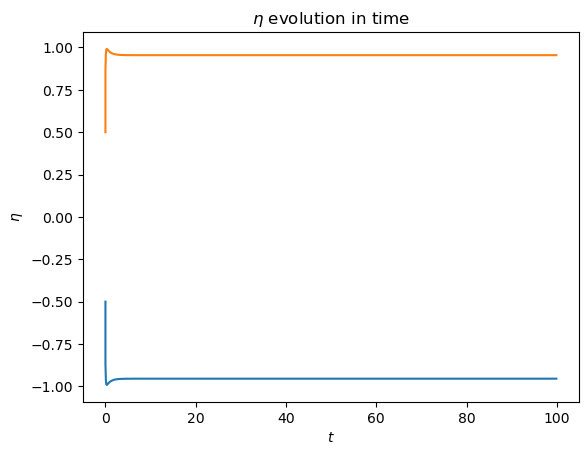

In [5]:
# plot solution trajectory
plt.plot(t2,X2[1,:])
plt.plot(t2,X2[2,:])
plt.xlabel("$t$")
plt.ylabel("$\eta$")
plt.title("$\eta$ evolution in time")
plt.show()

## Solve for equilibria and stability

In [6]:
# find equilibrium
def jac(x):
    j = MyJacobian(lambda y: IL(0,y,pars),x,1e-6)
    return np.squeeze(j)

x01 = np.array([-10,-0.5,0.5]) # initial guess
sol1 = root(lambda y: IL(0,y,pars), x01, jac=jac, method='hybr') # root finder

equi1 = sol1.x
equi1

array([-17.11772718,  -0.2498057 ,   0.2498057 ])

In [7]:
# check stability
eigs1 = linalg.eigvals(jac(equi1))
eigs1

array([ 1.95039324+0.j, -7.78804324+0.j, -3.93765   +0.j])

So we see this equilibrium is unstable.

In [8]:
# find other equilibrium
x02 = np.array([-10,-0.9,0.9]) 
sol2 = root(lambda y: IL(0,y,pars), x02, jac=jac, method='hybr')

equi2 = sol2.x
equi2

array([ 5.18772141, -0.95469445,  0.95469445])

In [9]:
# check stability
eigs2 = linalg.eigvals(jac(equi2))
eigs2

array([ -1.100159  +0.j, -15.84854748+0.j, -15.04870648+0.j])

So we see this equilibrium is stable.

## Bifurcation diagram in A

In [10]:
# Define RHS for tracking equilibria
RHS = lambda y: IL(0,y[0:3,:],np.array([R,Q,beta,a1,a2,y[3,:],B,C,T_c,p]))

h=1e-6
df= lambda y: np.squeeze(MyJacobian(RHS,y,h),axis=2)

# Define MyTrackCurve initial points
y0 = np.append(xeq1,np.array([A]),axis=0);
ytan0 = np.expand_dims(np.array([0,0,0,1]),axis=1); # guess in the direction of increasing F

# Solve for the true initial tangent
df0 = df(y0)
zeros0 = np.zeros((3,))
zeros1 = np.append(zeros0,np.array([1.]),axis=0)
f0 = np.concatenate((df0,np.transpose(ytan0)),axis=0)
z = np.linalg.lstsq(f0,zeros1,rcond=None)[0]
mult = np.sign(np.matmul(np.transpose(z),ytan0))
ytan = np.divide(z,linalg.norm(z))*mult

ylist1 = MyTrackCurve(RHS,df,y0,ytan,nmax=1000,stepsize=0.05);

# guess in direction for decreasing F
ytan0 = np.expand_dims(np.array([0,0,0,-1]),axis=1);

# Solve for the true initial tangent
f0 = np.concatenate((df0,np.transpose(ytan0)),axis=0)
z = np.linalg.lstsq(f0,zeros1,rcond=None)[0]
mult = np.sign(np.matmul(np.transpose(z),ytan0))
ytan = np.divide(z,linalg.norm(z))*mult

ylist2 = MyTrackCurve(RHS,df,y0,ytan,nmax=1000,stepsize=0.05)

C:\Users\swatt\AppData\Local\Temp\ipykernel_1720\315338610.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  RHS = lambda y: IL(0,y[0:3,:],np.array([R,Q,beta,a1,a2,y[3,:],B,C,T_c,p]))


In [11]:
ylist = np.concatenate((np.flip(ylist2,1),ylist1),axis=1);

# empty vector for stability
stab = np.empty((ylist.shape[1],1))*np.nan

for i in np.arange(0,ylist.shape[1]):
    pi =np.array([R,Q,beta,a1,a2,ylist[3,i],B,C,T_c,p])
    J = MyJacobian(lambda x: IL(0,x,pi),ylist[0:3,i],h)
    max_eig = max(np.real(linalg.eig(J[:,:,0])[0]))
    stab[i] = max_eig > 0
    if (i>0 and stab[i] != stab[i-1] and stab[i-1] != 10):
        #print(max_eig)
        stab[i] = 10

# define dark green color for Saddle-Node bifurcation marker
dg = (77./255, 149./255, 66./255)

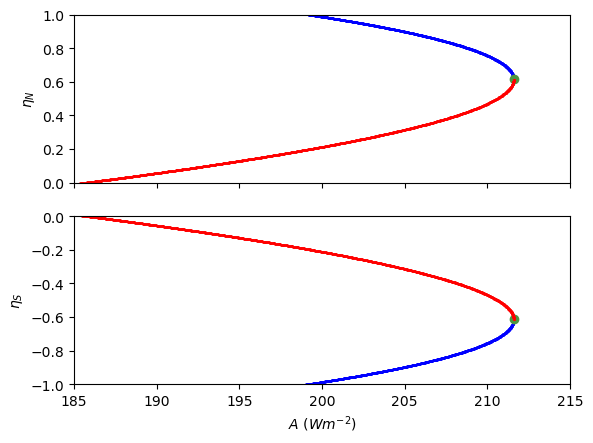

In [12]:
# plot in n
fig, (ax1, ax2) = plt.subplots(2, sharex=True)

# plot n_N
for i in np.arange(0,ylist.shape[1]):
    if stab[i] == False:
        ax1.plot(ylist[3,i],ylist[2,i],'b.',markersize=2,label = 'stable eq')
    elif stab[i] == True:
        ax1.plot(ylist[3,i],ylist[2,i],'r.',markersize=2,label = 'unstable eq')
    elif stab[i] == 10:
        ax1.plot(ylist[3,i],ylist[2,i],marker='o',color=dg,markersize=6,label='SN')
    else:
        print('Error - undefined stability type')

# plot n_S
for i in np.arange(0,ylist.shape[1]):
    if stab[i] == False:
        ax2.plot(ylist[3,i],ylist[1,i],'b.',markersize=2,label = 'stable eq')
    elif stab[i] == True:
        ax2.plot(ylist[3,i],ylist[1,i],'r.',markersize=2,label = 'unstable eq')
    elif stab[i] == 10:
        ax2.plot(ylist[3,i],ylist[1,i],marker='o',color=dg,markersize=6,label='SN')
    else:
        print('Error - undefined stability type')

ax1.set(ylabel = "$\eta_N$")
ax2.set(xlabel = "$A$ $(Wm^{-2})$", ylabel = "$\eta_S$")
ax1.set_xlim([185, 215])
ax2.set_xlim([185, 215])
ax1.set_ylim([0, 1])
ax2.set_ylim([-1, 0])
#plt.legend(loc ="upper left")
plt.show()

In [13]:
# find A value at SN
SNval = np.squeeze(np.argwhere(stab==10))[0]
ylist[3,SNval]

211.59360596971328

In [14]:
# find value where stable state becomes unphysical. 
Aval1 = np.squeeze(np.argwhere(ylist[1,:]>-1))[0]
ylist[3,Aval1]

199.18306880523883

In [15]:
# find value where unstable state becomes unphysical. 
Aval2 = np.squeeze(np.argwhere(ylist[1,:]>0))[0]
ylist[3,Aval2]

185.75614644851768

## 2-param continuation in A and T_c

In [16]:
# 2 param continuation
def df_2param(y):
    J = MyJacobian(lambda x: IL(0,x,np.array([R,Q,beta,a1,a2,y[3],B,C,y[4],p])),y[0:3],h)
    J = np.squeeze(J,axis=2)
    return J

RHS_fold = lambda y: np.append(IL(0,y[0:3,:],np.array([R,Q,beta,a1,a2,y[3,:],B,C,y[4,:],p])),
                               np.expand_dims(np.array([linalg.det(df_2param(y))]),axis=1),axis=0)

df_fold= lambda y: np.squeeze(MyJacobian(RHS_fold,y,h),axis=2)

# Define MyTrackCurve initial points
f_inds = np.where(stab == 10)[0]
y0 = np.append(ylist[:,f_inds[0]],np.array([T_c]),axis=0)
ytan0 = np.expand_dims(np.array([0,0,0,0,1]),axis=1) # guess i the direction of increasing params

# Solve for the true initial tangent
df0 = np.squeeze(df_fold(y0))
zeros0 = np.zeros((4,))
zeros1 = np.append(zeros0,np.array([1.]),axis=0)
f0 = np.concatenate((df0,np.transpose(ytan0)),axis=0)
z = np.linalg.lstsq(f0,zeros1,rcond=None)[0]
mult = np.sign(np.matmul(np.transpose(z),ytan0))
ytan = np.divide(z,linalg.norm(z))*mult

yfold1 = MyTrackCurve(RHS_fold,df_fold,y0,ytan,stepsize=1,nmax=200);

# guess in direction for decreasing params
ytan0 = np.expand_dims(np.array([0,0,0,0,-1]),axis=1)

# Solve for the true initial tangent
f0 = np.concatenate((df0,np.transpose(ytan0)),axis=0)
z = np.linalg.lstsq(f0,zeros1,rcond=None)[0]
mult = np.sign(np.matmul(np.transpose(z),ytan0))
ytan = np.divide(z,linalg.norm(z))*mult

yfold2 = MyTrackCurve(RHS_fold,df_fold,y0,ytan,stepsize=1,nmax=300);

C:\Users\swatt\AppData\Local\Temp\ipykernel_1720\274464745.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  RHS_fold = lambda y: np.append(IL(0,y[0:3,:],np.array([R,Q,beta,a1,a2,y[3,:],B,C,y[4,:],p])),
C:\Users\swatt\AppData\Local\Temp\ipykernel_1720\274464745.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  J = MyJacobian(lambda x: IL(0,x,np.array([R,Q,beta,a1,a2,y[3],B,C,y[4],p])),y[0:3],h)


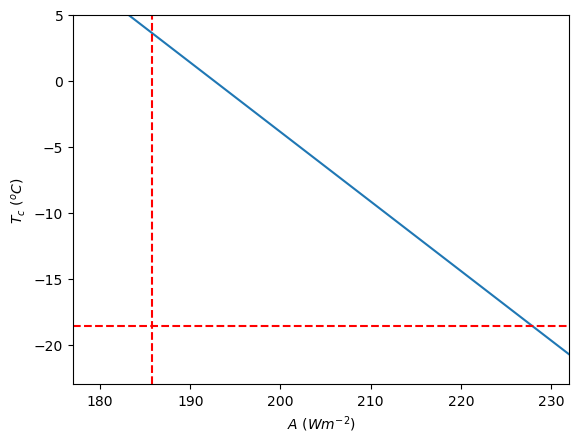

In [17]:
yfold = np.concatenate((np.flip(yfold2,1),yfold1),axis=1);

plt.plot(yfold[3,:],yfold[4,:])
plt.axhline(-18.561,linestyle='--', color='r')
plt.axvline(185.8,linestyle='--', color='r')
plt.xlabel("$A$ $(Wm^{-2})$")
plt.ylabel("$T_c$ $(^oC)$")
plt.axis([177,232,-23,5])

plt.show()

## Bifurcatons in $T_c$

In [18]:
# Define RHS for tracking equilibria
RHS = lambda y: IL(0,y[0:3,:],np.array([R,Q,beta,a1,a2,A,B,C,y[3,:],p]))

h=1e-6
df= lambda y: np.squeeze(MyJacobian(RHS,y,h),axis=2)

# Define MyTrackCurve initial points
y0 = np.append(xeq1,np.array([T_c]),axis=0);
ytan0 = np.expand_dims(np.array([0,0,0,1]),axis=1); # guess in the direction of increasing F

# Solve for the true initial tangent
df0 = df(y0)
zeros0 = np.zeros((3,))
zeros1 = np.append(zeros0,np.array([1.]),axis=0)
f0 = np.concatenate((df0,np.transpose(ytan0)),axis=0)
z = np.linalg.lstsq(f0,zeros1,rcond=None)[0]
mult = np.sign(np.matmul(np.transpose(z),ytan0))
ytan = np.divide(z,linalg.norm(z))*mult

ylist1 = MyTrackCurve(RHS,df,y0,ytan,nmax=1000,stepsize=0.05);

# guess in direction for decreasing F
ytan0 = np.expand_dims(np.array([0,0,0,-1]),axis=1);

# Solve for the true initial tangent
f0 = np.concatenate((df0,np.transpose(ytan0)),axis=0)
z = np.linalg.lstsq(f0,zeros1,rcond=None)[0]
mult = np.sign(np.matmul(np.transpose(z),ytan0))
ytan = np.divide(z,linalg.norm(z))*mult

ylist2 = MyTrackCurve(RHS,df,y0,ytan,nmax=1000,stepsize=0.05)

C:\Users\swatt\AppData\Local\Temp\ipykernel_1720\812319945.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  RHS = lambda y: IL(0,y[0:3,:],np.array([R,Q,beta,a1,a2,A,B,C,y[3,:],p]))


In [19]:
ylist = np.concatenate((np.flip(ylist2,1),ylist1),axis=1);

# empty vector for stability
stab = np.empty((ylist.shape[1],1))*np.nan

for i in np.arange(0,ylist.shape[1]):
    pi =np.array([R,Q,beta,a1,a2,A,B,C,ylist[3,i],p])
    J = MyJacobian(lambda x: IL(0,x,pi),ylist[0:3,i],h)
    max_eig = max(np.real(linalg.eig(J[:,:,0])[0]))
    stab[i] = max_eig > 0
    if (i>0 and stab[i] != stab[i-1] and stab[i-1] != 10):
        #print(max_eig)
        stab[i] = 10

# define dark green color for Saddle-Node bifurcation marker
dg = (77./255, 149./255, 66./255)

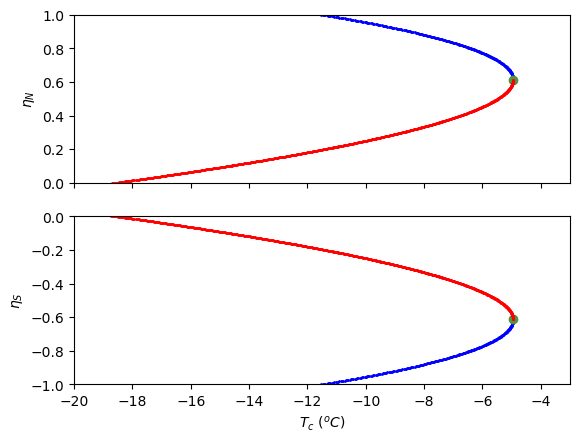

In [20]:
# plot in n
fig, (ax1, ax2) = plt.subplots(2, sharex=True)

# plot n_N
for i in np.arange(0,ylist.shape[1]):
    if stab[i] == False:
        ax1.plot(ylist[3,i],ylist[2,i],'b.',markersize=2,label = 'stable eq')
    elif stab[i] == True:
        ax1.plot(ylist[3,i],ylist[2,i],'r.',markersize=2,label = 'unstable eq')
    elif stab[i] == 10:
        ax1.plot(ylist[3,i],ylist[2,i],marker='o',color=dg,markersize=6,label='SN')
    else:
        print('Error - undefined stability type')

# plot n_S
for i in np.arange(0,ylist.shape[1]):
    if stab[i] == False:
        ax2.plot(ylist[3,i],ylist[1,i],'b.',markersize=2,label = 'stable eq')
    elif stab[i] == True:
        ax2.plot(ylist[3,i],ylist[1,i],'r.',markersize=2,label = 'unstable eq')
    elif stab[i] == 10:
        ax2.plot(ylist[3,i],ylist[1,i],marker='o',color=dg,markersize=6,label='SN')
    else:
        print('Error - undefined stability type')

ax1.set(ylabel = "$\eta_N$")
ax2.set(xlabel = "$T_c$ $(^oC)$", ylabel = "$\eta_S$")
ax1.set_xlim([-20, -3])
ax2.set_xlim([-20, -3])
ax1.set_ylim([0, 1])
ax2.set_ylim([-1, 0])
#plt.legend(loc ="upper left")
plt.show()

In [21]:
# find T_c value at SN
SNval = np.squeeze(np.argwhere(stab==10))[0]
ylist[3,SNval]

-4.950826206667241

In [22]:
# find value where stable state becomes unphysical. 
Tval1 = np.squeeze(np.argwhere(ylist[1,:]>-1))[0]
ylist[3,Tval1]

-11.478466113745226

In [23]:
# find value where unstable state becomes unphysical. 
Tval2 = np.squeeze(np.argwhere(ylist[1,:]>0))[0]
ylist[3,Tval2]

-18.56089754180989